In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import jax.numpy as jnp
import numpy as onp
from reusable.util import (
    load_args,
    load_training_history,
    load_scores,
    gen_file_name,
    get_decoder_params,
    load_training_state,
)
import matplotlib.pyplot as plt
from plotting.plots import plot_training, plot_draws_hpdi
import jax.random as random
from reusable.vae import VAE, vae_sample
from reusable.train_nn import SimpleTrainState
import optax
from numpyro.infer import Predictive
from reusable.gp import BuildGP
import pandas
import re


# Experiments for different loss functions

In [9]:
def align_right_backfill(count, num_rows, num_cols):
    return lambda i: i + num_cols * num_rows - count


def align_left_backfill(count, num_rows, num_cols):
    g = align_right_backfill(count, num_rows, num_cols)

    def func(i):
        if i < num_cols and i < num_cols - (num_cols * num_rows - count):
            return i
        return g(i)

    return func


def align_right_backfill_with_gp(count, num_rows, num_cols):
    # assume count includes the gp
    gap = num_cols * num_rows - count

    def func(i):
        if gap > 0 and i == 0:  # i.e. the GP
            return 0

        if i > 0:
            return i + num_cols * num_rows - count

    return func


def calc_dimensions(args, num_cols, num_rows, include_gp=False, extra_row_for_gp=False):
    # A = indexes over cols, B over rows - note flattening in code will
    if num_cols is None and num_rows is None:
        twoD = "Arange" in args and "Brange" in args
        num_cols = len(args["Arange"]) if twoD else 1
        num_rows = len(args["Brange"]) if twoD else len(args["loss_fns"])
    else:
        twoD = True
        assert num_cols is not None and num_rows is not None

    # add an extra row if asked, or if it won't fit in the grid
    if include_gp and (extra_row_for_gp or num_cols * num_rows - len(args["loss_fns"]) == 0):
        num_rows += 1

    return twoD, num_rows, num_cols


def clear_unused(axs, mapping, twoD, total):
    if not twoD:
        return
    num_rows, num_cols = axs.shape
    used_axes = [mapping(i) for i in range(total)]
    for i in range(num_cols * num_rows):
        if i not in used_axes:
            axs[onp.unravel_index(i, (num_rows, num_cols))].remove()


def pretty_loss_fn_name(loss_fn: str):
    RCL_LATEX = r"\mathrm{RCL}"
    KLD_LATEX = r"\mathrm{KLD}"
    MMD_RBF_LATEX = r"\mathrm{MMD}_\mathrm{rbf}"
    MMD_RQK_LATEX = r"\mathrm{MMD}_\mathrm{rq}"
    parts = loss_fn.split("+")
    after = ""
    for i, part in enumerate(parts):

        if i > 0:
            after += "+"

        split = re.split(r"([a-zA-Z\s]+)", part)
        factor = split[0]
        part = "".join(split[1:])
        if factor != "":
            after += factor

        if part == "RCL":
            after += RCL_LATEX
        if part == "KLD":
            after += KLD_LATEX
        if part.startswith("mmd"):
            mmd, lss = part.split("-", 1)
            mult = lss.split(";")
            for m in mult:
                if mmd == "mmd_rbf_sum":
                    m = float(m)
                    s = str(int(m)) if m.is_integer() else f"{m:.2f}"
                    after += f"{MMD_RBF_LATEX}({s})"
                if mmd == "mmd_rqk_sum":
                    ls, a = m.split(",", 1)
                    ls = float(ls)
                    a = float(a)
                    ls_s = str(int(ls)) if ls.is_integer() else f"{ls:.2f}"
                    ls_a = str(int(a)) if a.is_integer() else f"{a:.2f}"
                    after += f"{MMD_RQK_LATEX}({ls_s},{ls_a})"

    return f"${after}$"


In [5]:
def plot_training_histories(exp_name, args_count, num_cols=None, num_rows=None, backfill=None):
    args = load_args("16", args_count, exp_name)

    twoD, num_rows, num_cols = calc_dimensions(args, num_cols, num_rows, False, False)

    match backfill:
        case None:
            mapping = lambda i: i
        case "align_left":
            mapping = align_left_backfill(len(args["loss_fns"]), num_rows, num_cols)
        case "align_right":
            mapping = align_right_backfill(len(args["loss_fns"]), num_rows, num_cols)

    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols * 6, num_rows * 5))

    clear_unused(axs, mapping, twoD, len(args["loss_fn_names"]))

    for i, loss_fn in enumerate(args["loss_fn_names"]):

        hist = load_training_history("16", gen_file_name("16", args, args["experiment"] + loss_fn))
        plot_training(
            hist["test_loss"],
            hist["train_loss"],
            pretty_loss_fn_name(loss_fn),
            ax=axs[onp.unravel_index(mapping(i), (num_rows, num_cols)) if twoD else i],
        )

    fig.tight_layout()
    
    fig.savefig(f"./gen_plots/16/16_{exp_name}_{args_count}_training.png")


In [6]:
def plot_trained_draws(exp_name, args_count, num_cols=None, num_rows=None, backfill=None, separate_gp=False):
    rng_key = random.PRNGKey(3)
    rng_key, rng_key_gp = random.split(rng_key, 2)

    args = load_args("16", args_count, exp_name)

    twoD, num_rows, num_cols = calc_dimensions(args, num_cols, num_rows, True, separate_gp)

    match backfill:
        case None:
            if separate_gp:
                mapping = lambda i: 0 if i == 0 else i - 1 + num_cols
            else:
                mapping = lambda i: i
        case "align_left":
            mapping = align_left_backfill(len(args["loss_fns"]) + 1, num_rows, num_cols)
        case "align_right":
            mapping = align_right_backfill_with_gp(len(args["loss_fns"]) + 1, num_rows, num_cols)

    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols * 6, num_rows * 5))

    clear_unused(axs, mapping, twoD, len(args["loss_fn_names"]) + 1)

    gp = BuildGP(
        args["gp_kernel"],
        noise=False,
        length_prior_choice=args["length_prior_choice"],
        prior_args=args["length_prior_arguments"],
    )

    plot_gp_predictive = Predictive(gp, num_samples=1000)

    gp_draws = plot_gp_predictive(rng_key_gp, x=args["x"], gp_kernel=args["gp_kernel"], jitter=1e-5)["y"]
    plot_draws_hpdi(
        gp_draws,
        args["x"],
        f"GP draws",
        "$y=f_{GP}(x)$",
        "GP",
        ax=axs[onp.unravel_index(mapping(0), (num_rows, num_cols)) if twoD else 0],
    )

    for i, loss_fn in enumerate(args["loss_fn_names"]):
        rng_key, rng_key_init, rng_key_predict = random.split(rng_key, 3)

        module = VAE(
            hidden_dim1=args["hidden_dim1"],
            hidden_dim2=args["hidden_dim2"],
            latent_dim=args["latent_dim"],
            out_dim=args["n"],
            conditional=False,
        )
        params = module.init(rng_key, jnp.ones((args["n"],)))["params"]
        tx = optax.adam(args["learning_rate"])
        state = SimpleTrainState.create(apply_fn=module.apply, params=params, tx=tx, key=rng_key_init)

        decoder_params = get_decoder_params(
            load_training_state("16", gen_file_name("16", args, args["experiment"] + loss_fn), state)
        )

        plot_vae_predictive = Predictive(vae_sample, num_samples=1000)
        vae_draws = plot_vae_predictive(
            rng_key_predict,
            hidden_dim1=args["hidden_dim1"],
            hidden_dim2=args["hidden_dim2"],
            latent_dim=args["latent_dim"],
            out_dim=args["n"],
            decoder_params=decoder_params,
        )["f"]
        plot_draws_hpdi(
            vae_draws,
            args["x"],
            pretty_loss_fn_name(loss_fn),
            "$y=f_{VAE}(x)$",
            "PriorVAE",
            ax=axs[onp.unravel_index(mapping(i + 1), (num_rows, num_cols)) if twoD else i + 1],
        )

    fig.tight_layout()

    fig.savefig(f"./gen_plots/16/16_{exp_name}_{args_count}_draws.png")


In [7]:
def merge_dicts(a: dict, b: dict):
    for key, val in b.items():
        if len(val) > 0 and isinstance(val[0], str):
            if key not in a:
                a[key] = [val]
            else:
                a[key] = a[key] + [val]
        else:
            if key not in a:
                a[key] = jnp.array(val)[None]
            else:
                a[key] = jnp.concatenate((a[key], jnp.array(val)[None]), axis=0)


def get_loss_scores(exp_name, args_count):
    """Given the raw data (which is v. oddly formatted), return a dictionary of lists:
    - loss_fns
    - frobenius: items: array of length num_orders_calced
    - vae_moments: 2d array: (num_orders, n)
    - mmd: items: array of values for each kernel choice
    - mmd_kernels: list of string names
    """
    args = load_args("16", args_count, exp_name)

    scores = {"loss_fns": []}
    for i, loss_fn in enumerate(args["loss_fn_names"]):
        scores["loss_fns"].append(loss_fn)
        s = load_scores(
            args["expcode"],
            gen_file_name("16", args, args["experiment"] + loss_fn),
        )
        s["mmd_kernels"] = [x[0] for x in s["mmd"]]
        s["mmd"] = [x[1] for x in s["mmd"]]
        merge_dicts(scores, s)

    return scores


from IPython.display import display

pandas.options.display.latex.repr = True


def show_loss_scores(exp_name, args_count):

    scores = get_loss_scores(exp_name, args_count)

    scores["avg_vae_moments"] = scores["vae_moments"].mean(axis=-1)

    to_plot = ["frobenius", "mmd"]  # "avg_vae_moments",
    std_range = [1, 2, 3, 4, 5, 6, 7, 8, 9]
    col_labels = ["Moment", "MMD kernel"]
    pretty_labels = [std_range, [pretty_loss_fn_name(x) for x in scores["mmd_kernels"][0]]]
    labels = [std_range, scores["mmd_kernels"][0]]

    for p, l, c in zip(to_plot, labels, col_labels):
        df = pandas.DataFrame(
            scores[p],
            columns=pandas.Index(l, name=c),
            index=pandas.Index([pretty_loss_fn_name(x) for x in scores["loss_fns"]], name="Loss functions"),
        )

        s = df.style.highlight_min(axis=0, props="bfseries: ;")

        with open(f"./gen_plots/16/16_{exp_name}_{args_count}_{p}_table.tex", "w") as f:
            s.to_latex(f)

        with open(f"./gen_plots/16/16_{exp_name}_{args_count}_{p}_table.str", "w") as f:
            df.to_string(f)

        df = pandas.DataFrame(
            scores[p], columns=pandas.Index(l, name=c), index=pandas.Index(scores["loss_fns"], name="Loss functions")
        )

        s = df.style.highlight_min(axis=0, props="font-weight:bold;")
        display(s)

    pass


Moment,1,2,3,4,5,6,7,8,9
Loss functions,,,,,,,,,
10RCL+mmd_rbf_sum-4.0+KLD,1100.407715,569.525757,628.165710,693.400696,856.915039,1213.961548,1658.780518,2172.233643,2674.027100
RCL+mmd_rbf_sum-4.0+KLD,844.511414,982.815247,988.957336,1210.904419,1368.960815,1662.685303,2007.153687,2429.942871,2853.670654
0.1RCL+mmd_rbf_sum-4.0+KLD,446.954956,728.243530,681.303223,890.848450,893.984863,982.343994,1044.294800,1185.691406,1376.502808
0.01RCL+mmd_rbf_sum-4.0+KLD,265.697418,651.153748,711.054626,1084.399658,1440.624146,2076.004883,2724.865234,3400.662842,3981.355957
10RCL+5mmd_rbf_sum-4.0+KLD,487.685089,723.655151,643.174011,944.439697,960.053467,1175.109497,1399.987061,1759.770752,2135.512695
RCL+5mmd_rbf_sum-4.0+KLD,855.242615,1050.950317,1092.592773,1347.177612,1470.747192,1700.092773,1971.189453,2326.870117,2704.719971
0.1RCL+5mmd_rbf_sum-4.0+KLD,332.131195,719.225281,813.711182,1106.675171,1239.180420,1441.795410,1702.754639,2099.769043,2553.434326
0.01RCL+5mmd_rbf_sum-4.0+KLD,230.458817,397.330139,494.216553,587.208862,554.434143,525.863525,676.563721,1012.239563,1379.360229
10RCL+10mmd_rbf_sum-4.0+KLD,469.830261,790.288818,777.312988,1003.106384,1018.081482,1094.311646,1143.782104,1286.312988,1494.646240


MMD kernel,mmd_rbf_sum-1.0,mmd_rbf_sum-4.0,mmd_rbf_sum-10.0,"mmd_rqk_sum-4.0,0.25","mmd_rqk_sum-8.0,0.25","mmd_rqk_sum-4.0,1","mmd_rqk_sum-8.0,1","mmd_rqk_sum-4.0,10","mmd_rqk_sum-8.0,10","mmd_rqk_sum-4.0,100","mmd_rqk_sum-8.0,100"
Loss functions,,,,,,,,,,,
10RCL+mmd_rbf_sum-4.0+KLD,0.011133,0.165032,0.145893,0.082764,0.059429,0.147709,0.092771,0.193121,0.118199,0.197812,0.122228
RCL+mmd_rbf_sum-4.0+KLD,0.015844,0.114977,0.104174,0.058968,0.042230,0.103521,0.066433,0.132887,0.085402,0.135645,0.088422
0.1RCL+mmd_rbf_sum-4.0+KLD,0.000943,0.013515,0.021135,0.009546,0.008008,0.016407,0.013704,0.019293,0.018590,0.019296,0.019351
0.01RCL+mmd_rbf_sum-4.0+KLD,0.000068,0.000827,0.001068,0.000545,0.000451,0.000900,0.000754,0.001036,0.000976,0.001040,0.001003
10RCL+5mmd_rbf_sum-4.0+KLD,0.012405,0.213550,0.186742,0.106343,0.076382,0.191371,0.118645,0.253268,0.150087,0.260071,0.155019
RCL+5mmd_rbf_sum-4.0+KLD,0.014279,0.103007,0.092703,0.052686,0.037677,0.092389,0.059229,0.118504,0.076095,0.120972,0.078770
0.1RCL+5mmd_rbf_sum-4.0+KLD,0.000211,0.005024,0.012553,0.004962,0.004588,0.008344,0.008204,0.009090,0.011406,0.008912,0.011901
0.01RCL+5mmd_rbf_sum-4.0+KLD,0.000073,0.000434,0.000376,0.000217,0.000149,0.000359,0.000243,0.000417,0.000332,0.000419,0.000347
10RCL+10mmd_rbf_sum-4.0+KLD,0.014171,0.242080,0.205115,0.118826,0.084750,0.213631,0.130869,0.283309,0.164647,0.291177,0.169903


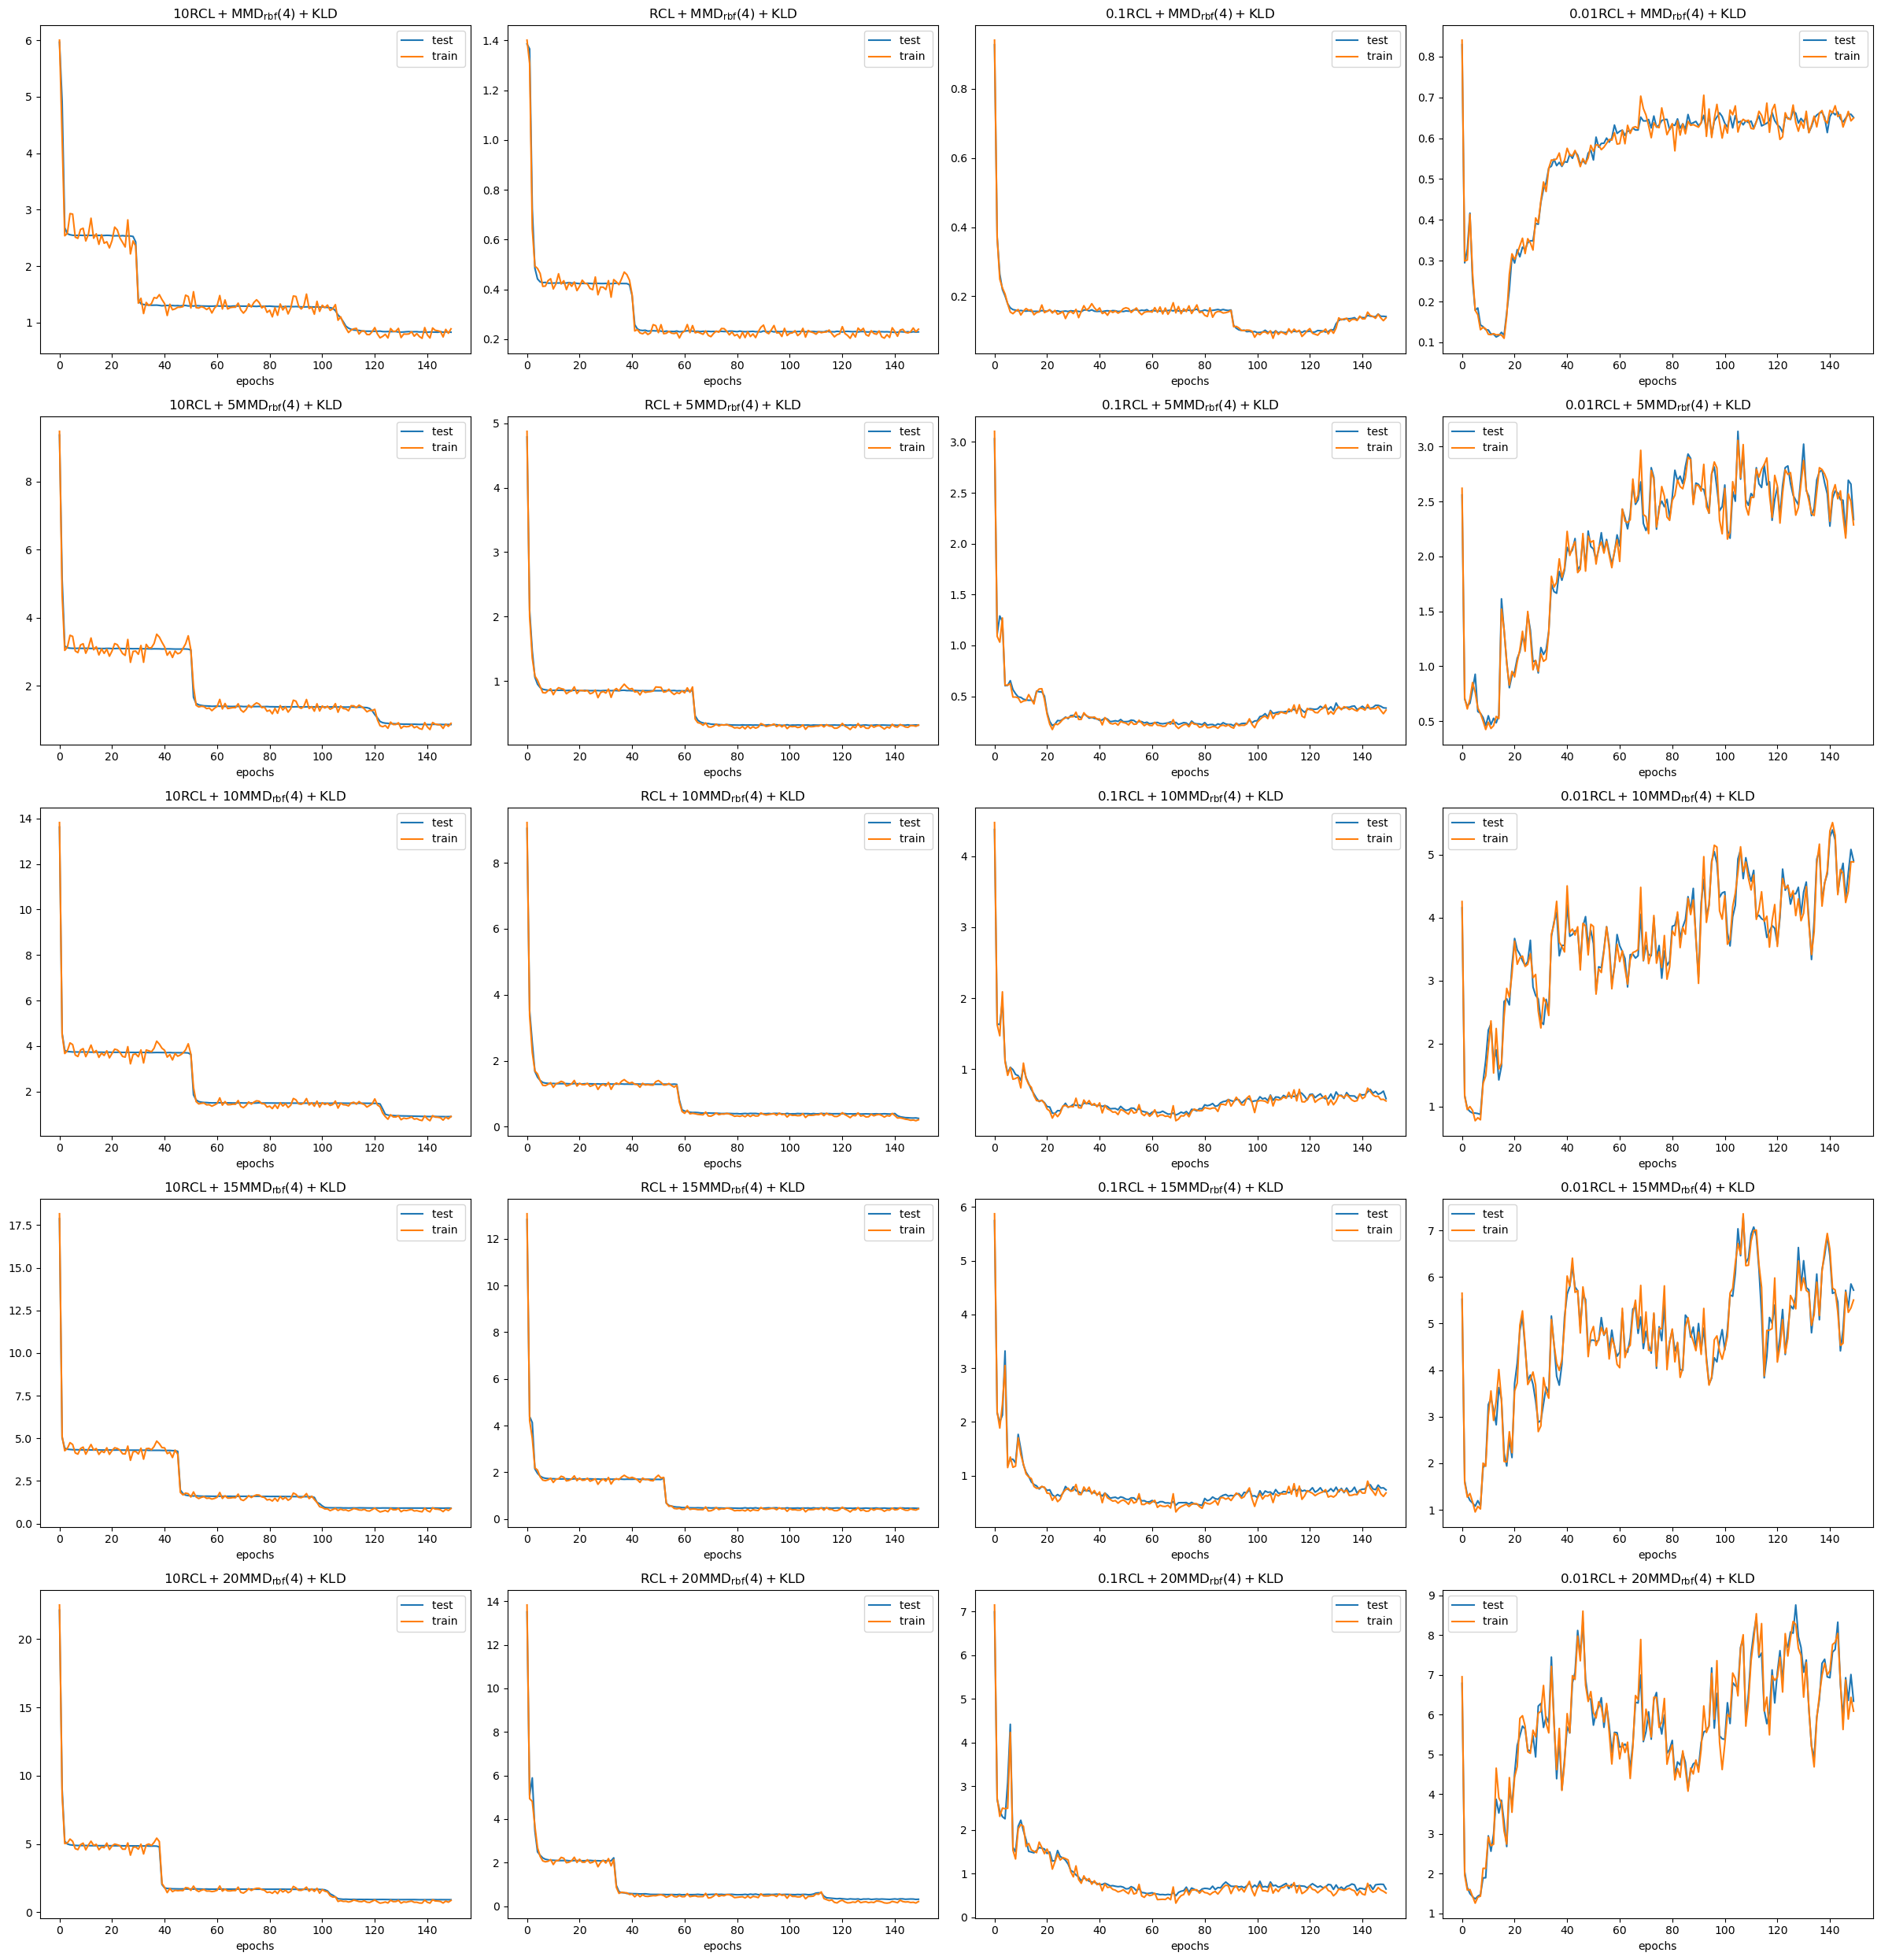

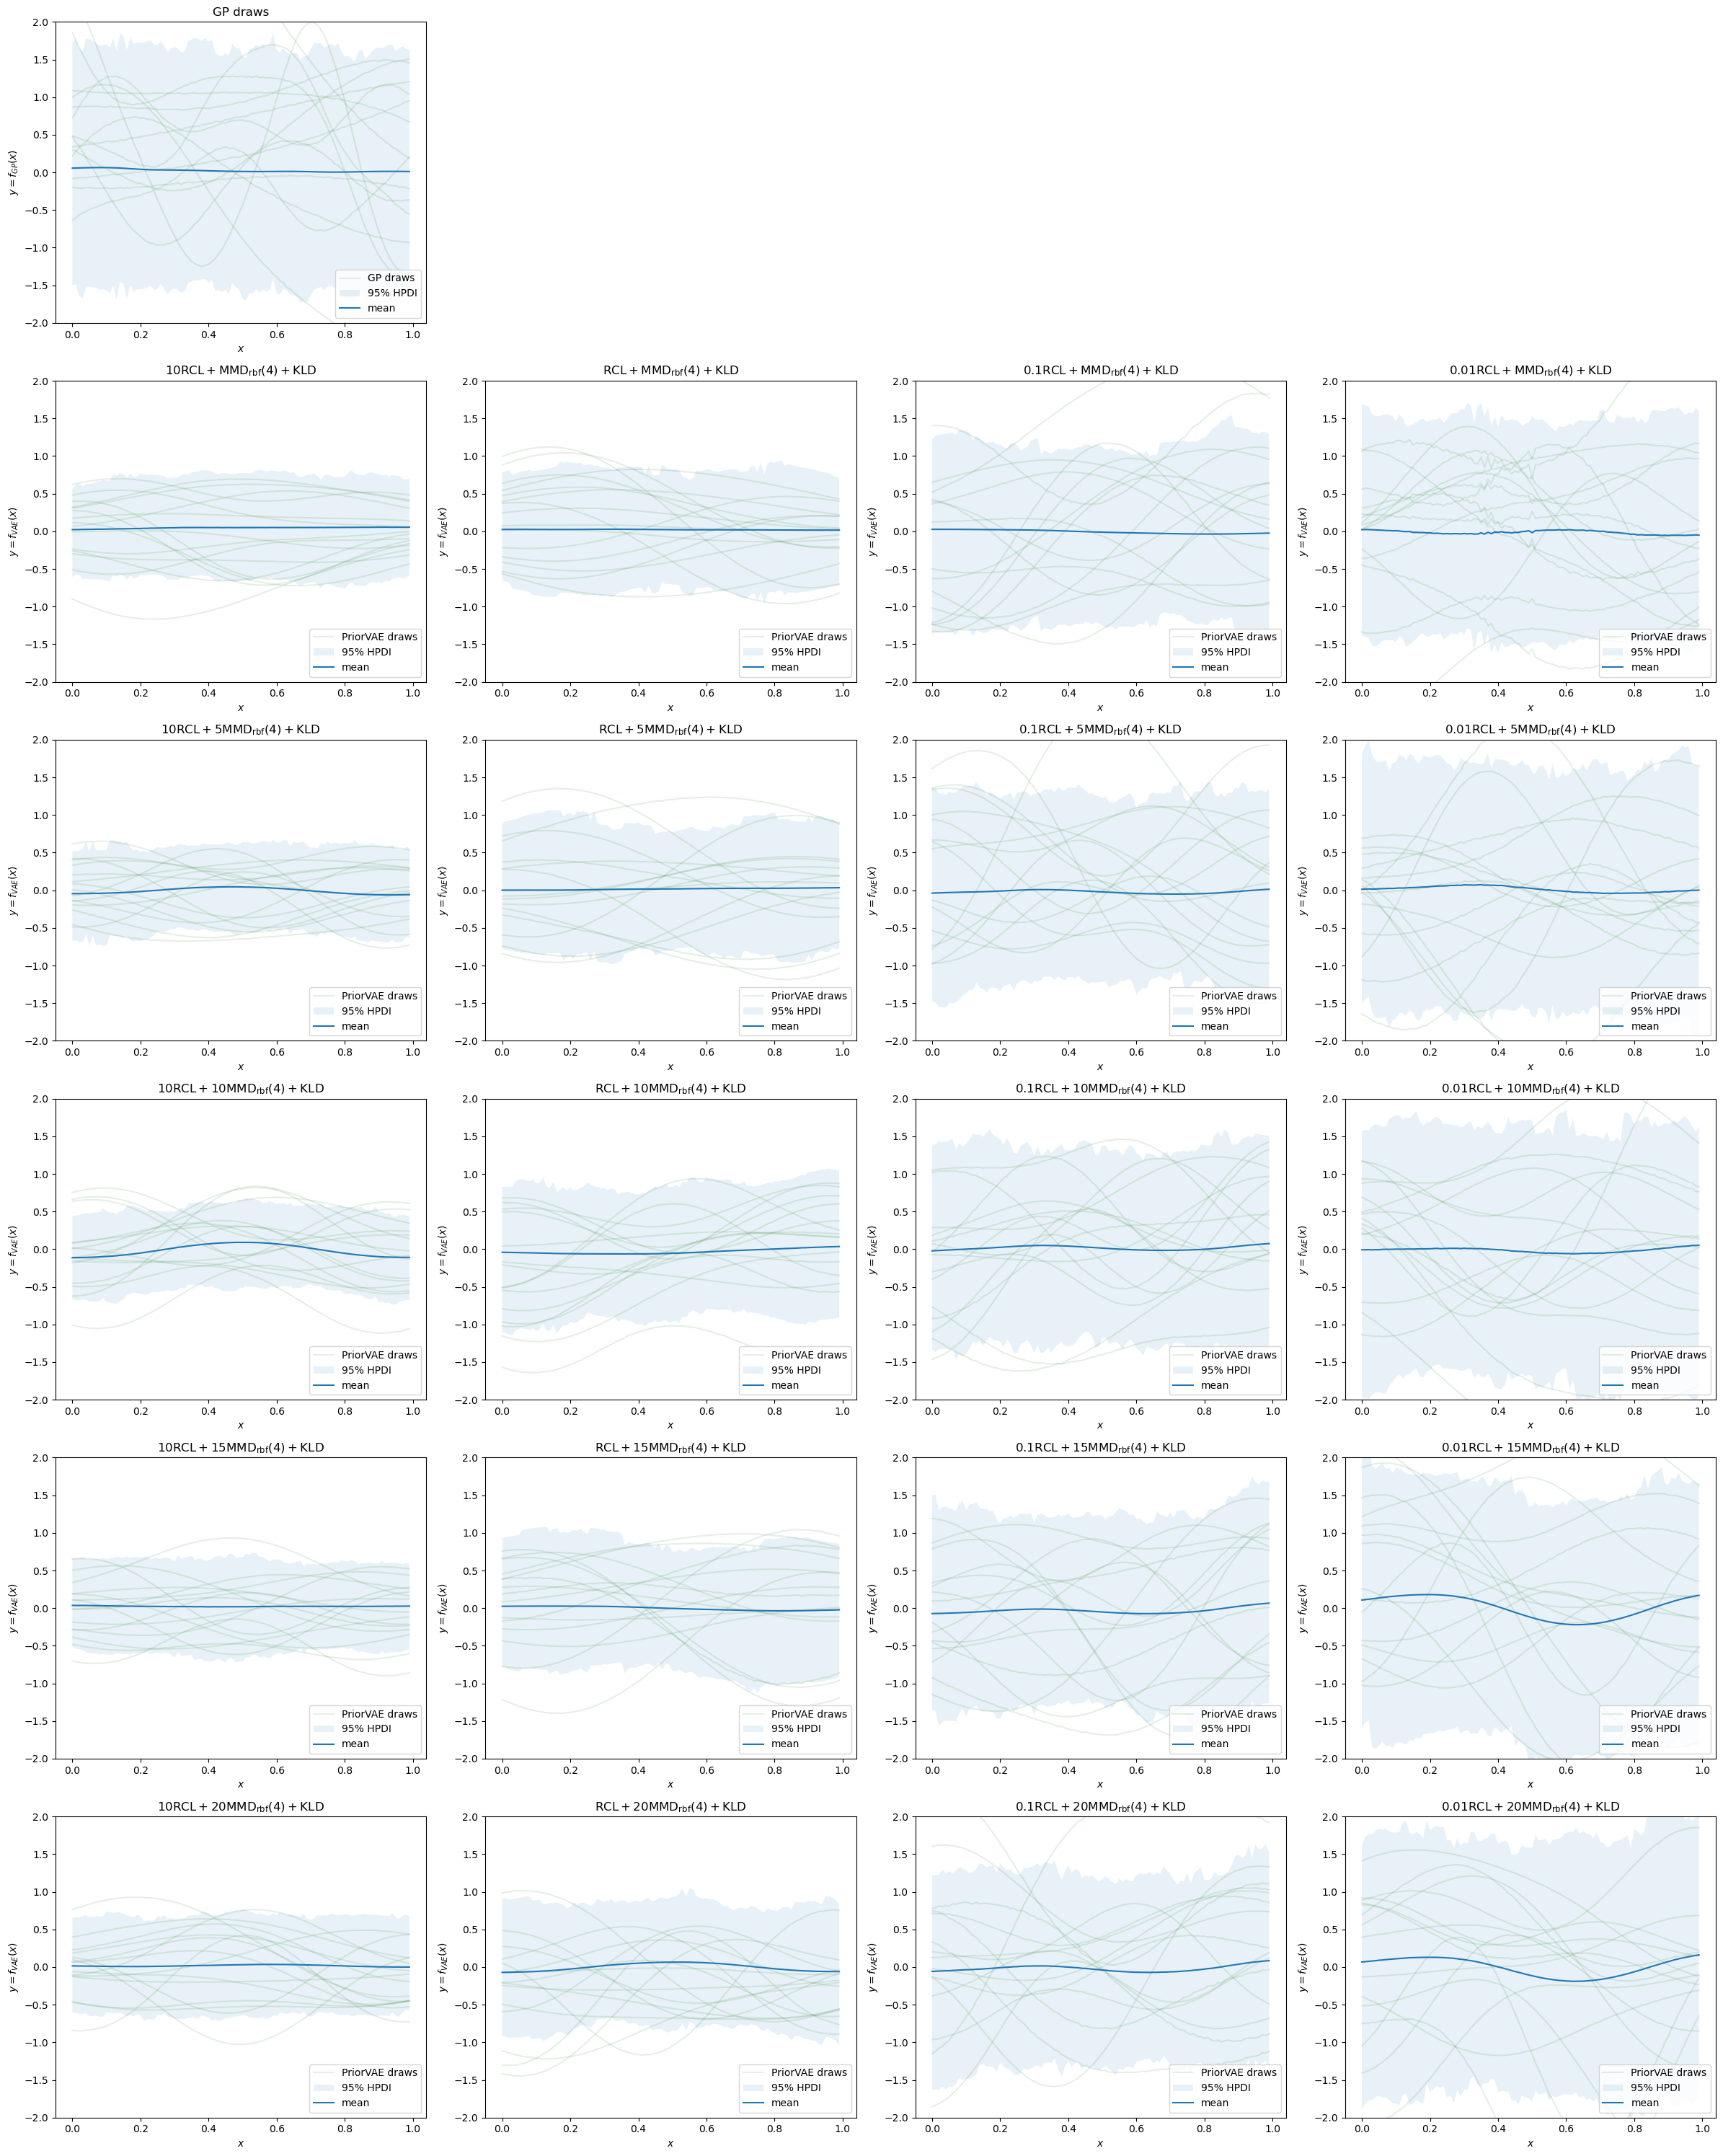

In [14]:
experiment = "exp3"
number = "1" # disambiguate argument files

show_loss_scores(experiment, number)
plot_training_histories(experiment, number, backfill="align_right")
plot_trained_draws(experiment, number,  backfill="align_right")
# plot_training_histories(experiment, number, num_cols=4, num_rows=3, backfill="align_right")
# plot_trained_draws(experiment, number, num_cols=4, num_rows=3, backfill="align_right")